# Previsão de Demanda com Séries Temporais

In [221]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import acf, adfuller, ccf, pacf

In [222]:
debug = False

In [223]:
df = pd.read_csv("df_case_1_-_500_linhas.csv")

In [224]:
df.head()

,CATEGORIA,PRODUTO,FORNECEDOR,COMPRADOR,CENTROS DE DISTRIBUICAO,DESCRICAO,QTD DE CAIXAS,MAR22,ABR22,MAI22,...,JUN23,JUL23,AGO23,SET23,OUT23,NOV23,DEZ23,JAN24,FEV24,MAR24
0,A,A,A,A,A,A,109,356,374,408,...,404,350,466,290,476,524,273,199,313,197
1,A,A,A,A,B,B,70,994,723,1310,...,1897,1840,2427,1655,1669,1970,1700,1895,1385,2243
2,B,B,B,B,C,C,123,74,65,71,...,144,57,69,165,129,153,149,145,125,132
3,B,C,C,C,D,D,196,520,466,603,...,496,568,443,304,408,372,315,447,610,776
4,A,D,A,A,E,E,99,37,1,78,...,75,60,85,13,45,24,8,64,79,96


Até a 7a coluna, temos dados categóricos e quantidade de caixas.\
Suposição: a coluna QTD DE CAIXAS representa o estoque de mercadoria.\
Da 8a coluna em diante, temos a série temporal.

## Análise de dados de estoque

In [225]:
df_estoque = df[df.columns[:7]]

In [226]:
df_estoque.head()

,CATEGORIA,PRODUTO,FORNECEDOR,COMPRADOR,CENTROS DE DISTRIBUICAO,DESCRICAO,QTD DE CAIXAS
0,A,A,A,A,A,A,109
1,A,A,A,A,B,B,70
2,B,B,B,B,C,C,123
3,B,C,C,C,D,D,196
4,A,D,A,A,E,E,99


In [227]:
# verificação de quantidade de combinações possíveis entre CATEGORIA e PRODUTO
df_estoque.groupby(["CATEGORIA", "PRODUTO"]).size().groupby(
    ["PRODUTO"]
).size().value_counts()

1    11
2     8
3     7
Name: count, dtype: int64

Podemos encontrar um mesmo código de PRODUTO em 2 ou mais CATEGORIAs.

In [228]:
# quantidade de combinações para todas as variáveis categóricas
df_estoque.groupby(
    ["CATEGORIA", "PRODUTO", "CENTROS DE DISTRIBUICAO", "COMPRADOR", "FORNECEDOR"]
)["DESCRICAO"].nunique().value_counts()

DESCRICAO
1    255
2     75
3     18
4      6
5      1
Name: count, dtype: int64

Podemos encontrar também diferentes descrições para uma mesma combinação de CATEGORIA, PRODUTO, CENTROS DE DISTRIBUICAO, COMPRADOR e FORNECEDOR.

In [229]:
df_estoque.groupby(["CATEGORIA", "PRODUTO", "CENTROS DE DISTRIBUICAO"])[
    "COMPRADOR"
].nunique().value_counts()

COMPRADOR
1    341
2      7
Name: count, dtype: int64

Também encontramos diferentes fornecedores para uma mesma combinaçao de CATEGORIA, PRODUTO e CENTROS DE DISTRIBUICAO.\
Assim, consideraremos todas as variáveis categóricas para a formação de chaves unívocas, sem agrupar séries diferentes.\
(Um exemplo seria unificar estoques da mesma CATEGORIA, PRODUTO, CENTROS DE DISTRIBUIÇÃO mas com COMPRADOR diferente.)

## Preparação dos dados de vendas

In [230]:
# criação de chave unívoca
col_key = (
    df["CATEGORIA"]
    + df["PRODUTO"]
    + df["FORNECEDOR"]
    + df["COMPRADOR"]
    + df["CENTROS DE DISTRIBUICAO"]
    + df["DESCRICAO"]
)
df.insert(0, "KEY", col_key)

In [231]:
df.describe(include=object)

,KEY,CATEGORIA,PRODUTO,FORNECEDOR,COMPRADOR,CENTROS DE DISTRIBUICAO,DESCRICAO
count,500,500,500,500,500,500,500
unique,488,7,26,26,4,26,26
top,ASGCCK,B,R,A,C,D,N
freq,3,271,42,85,227,40,23


Chama a atenção que a chave, supostamente única, se repete.\
Para evitar erros, é necessário criar sufixos.

In [232]:
col_cumcount = df.groupby("KEY").cumcount() + 1
col_key_suffix = col_cumcount.apply(lambda x: str(x) if x > 1 else "")
df["KEY"] = df["KEY"] + col_key_suffix

In [233]:
df.describe(include=object)

,KEY,CATEGORIA,PRODUTO,FORNECEDOR,COMPRADOR,CENTROS DE DISTRIBUICAO,DESCRICAO
count,500,500,500,500,500,500,500
unique,500,7,26,26,4,26,26
top,AAAAAA,B,R,A,C,D,N
freq,1,271,42,85,227,40,23


In [234]:
df[df["KEY"].str.startswith("ASGCCK")]

,KEY,CATEGORIA,PRODUTO,FORNECEDOR,COMPRADOR,CENTROS DE DISTRIBUICAO,DESCRICAO,QTD DE CAIXAS,MAR22,ABR22,...,JUN23,JUL23,AGO23,SET23,OUT23,NOV23,DEZ23,JAN24,FEV24,MAR24
151,ASGCCK,A,S,G,C,C,K,90,43,96,...,41,35,105,44,71,56,74,30,61,47
345,ASGCCK2,A,S,G,C,C,K,62,50,115,...,7,18,85,123,123,83,26,66,110,78
381,ASGCCK3,A,S,G,C,C,K,183,966,1779,...,1852,5133,2085,809,2392,3463,3587,2803,1773,1327


Observação das colunas de meses

In [235]:
df.columns[8:]

Index(['MAR22', 'ABR22', 'MAI22', 'JUN22', 'JUL22', 'AGO22', 'SET22', 'OUT22',
       'NOV22', 'DEZ22', 'JAN23', 'FEV23', 'MAR23', 'ABR23', 'MAI23', 'JUN23',
       'JUL23', 'AGO23', 'SET23', 'OUT23', 'NOV23', 'DEZ23', 'JAN24', 'FEV24',
       'MAR24'],
      dtype='object')

In [236]:
pd.period_range("2022-03-01", "2024-03-01", freq="M")

PeriodIndex(['2022-03', '2022-04', '2022-05', '2022-06', '2022-07', '2022-08',
             '2022-09', '2022-10', '2022-11', '2022-12', '2023-01', '2023-02',
             '2023-03', '2023-04', '2023-05', '2023-06', '2023-07', '2023-08',
             '2023-09', '2023-10', '2023-11', '2023-12', '2024-01', '2024-02',
             '2024-03'],
            dtype='period[M]')

In [237]:
# mapeamento para traduzir mês/ano para paríodo
month_map = dict(
    zip(df.columns[8:], pd.period_range("2022-03-01", "2024-03-01", freq="M"))
)
month_map

{'MAR22': Period('2022-03', 'M'),
 'ABR22': Period('2022-04', 'M'),
 'MAI22': Period('2022-05', 'M'),
 'JUN22': Period('2022-06', 'M'),
 'JUL22': Period('2022-07', 'M'),
 'AGO22': Period('2022-08', 'M'),
 'SET22': Period('2022-09', 'M'),
 'OUT22': Period('2022-10', 'M'),
 'NOV22': Period('2022-11', 'M'),
 'DEZ22': Period('2022-12', 'M'),
 'JAN23': Period('2023-01', 'M'),
 'FEV23': Period('2023-02', 'M'),
 'MAR23': Period('2023-03', 'M'),
 'ABR23': Period('2023-04', 'M'),
 'MAI23': Period('2023-05', 'M'),
 'JUN23': Period('2023-06', 'M'),
 'JUL23': Period('2023-07', 'M'),
 'AGO23': Period('2023-08', 'M'),
 'SET23': Period('2023-09', 'M'),
 'OUT23': Period('2023-10', 'M'),
 'NOV23': Period('2023-11', 'M'),
 'DEZ23': Period('2023-12', 'M'),
 'JAN24': Period('2024-01', 'M'),
 'FEV24': Period('2024-02', 'M'),
 'MAR24': Period('2024-03', 'M')}

In [238]:
df_renamed = df.rename(columns=month_map)

In [239]:
df_long = pd.melt(
    df_renamed,
    id_vars=df_renamed.columns[:8],
    value_vars=df_renamed.columns[8:],
    var_name="MESANO",
    value_name="VENDAS",
)
df_long["MESANO"] = pd.to_datetime(df_long["MESANO"].astype(str))

df_long.head()

,KEY,CATEGORIA,PRODUTO,FORNECEDOR,COMPRADOR,CENTROS DE DISTRIBUICAO,DESCRICAO,QTD DE CAIXAS,MESANO,VENDAS
0,AAAAAA,A,A,A,A,A,A,109,2022-03-01,356
1,AAAABB,A,A,A,A,B,B,70,2022-03-01,994
2,BBBBCC,B,B,B,B,C,C,123,2022-03-01,74
3,BCCCDD,B,C,C,C,D,D,196,2022-03-01,520
4,ADAAEE,A,D,A,A,E,E,99,2022-03-01,37


Derivação de mês e ano

In [240]:
df_long["MES"] = df_long["MESANO"].dt.month
df_long["ANO"] = df_long["MESANO"].dt.year
col_vendas = df_long.pop("VENDAS")
df_long.insert(df_long.columns.size, "VENDAS", col_vendas)

df_long.head()

,KEY,CATEGORIA,PRODUTO,FORNECEDOR,COMPRADOR,CENTROS DE DISTRIBUICAO,DESCRICAO,QTD DE CAIXAS,MESANO,MES,ANO,VENDAS
0,AAAAAA,A,A,A,A,A,A,109,2022-03-01,3,2022,356
1,AAAABB,A,A,A,A,B,B,70,2022-03-01,3,2022,994
2,BBBBCC,B,B,B,B,C,C,123,2022-03-01,3,2022,74
3,BCCCDD,B,C,C,C,D,D,196,2022-03-01,3,2022,520
4,ADAAEE,A,D,A,A,E,E,99,2022-03-01,3,2022,37


Assim, temos as séries temporais em dois formatos:
- `df` com as séries temporais completas em formato `wide`
- `df_long` com as séries temporais em formato `long`

## Análise de dados de vendas

In [241]:
df_long.describe(include=object)

,KEY,CATEGORIA,PRODUTO,FORNECEDOR,COMPRADOR,CENTROS DE DISTRIBUICAO,DESCRICAO
count,12500,12500,12500,12500,12500,12500,12500
unique,500,7,26,26,4,26,26
top,AAAAAA,B,R,A,C,D,N
freq,25,6775,1050,2125,5675,1000,575


In [242]:
df_long.describe(include=np.number)

,QTD DE CAIXAS,MES,ANO,VENDAS
count,12500.000000,12500.000000,12500.000000,12500.000000
mean,104.142000,6.360000,2022.720000,326.314800
std,80.749288,3.451283,0.664556,994.210272
min,7.000000,1.000000,2022.000000,-38.000000
25%,62.000000,3.000000,2022.000000,51.000000
50%,92.000000,6.000000,2023.000000,88.500000
75%,125.250000,9.000000,2023.000000,199.000000
max,1059.000000,12.000000,2024.000000,22181.000000


In [243]:
df["PRODUTO"].value_counts()

PRODUTO
R    42
S    41
G    39
B    39
K    34
P    29
A    27
F    26
D    26
J    24
I    19
T    17
H    16
M    15
V    14
C    14
E    13
X    12
W    11
Q    10
Y     7
O     7
L     7
N     5
Z     5
U     1
Name: count, dtype: int64

### Correlação das séries dentro de cada produto

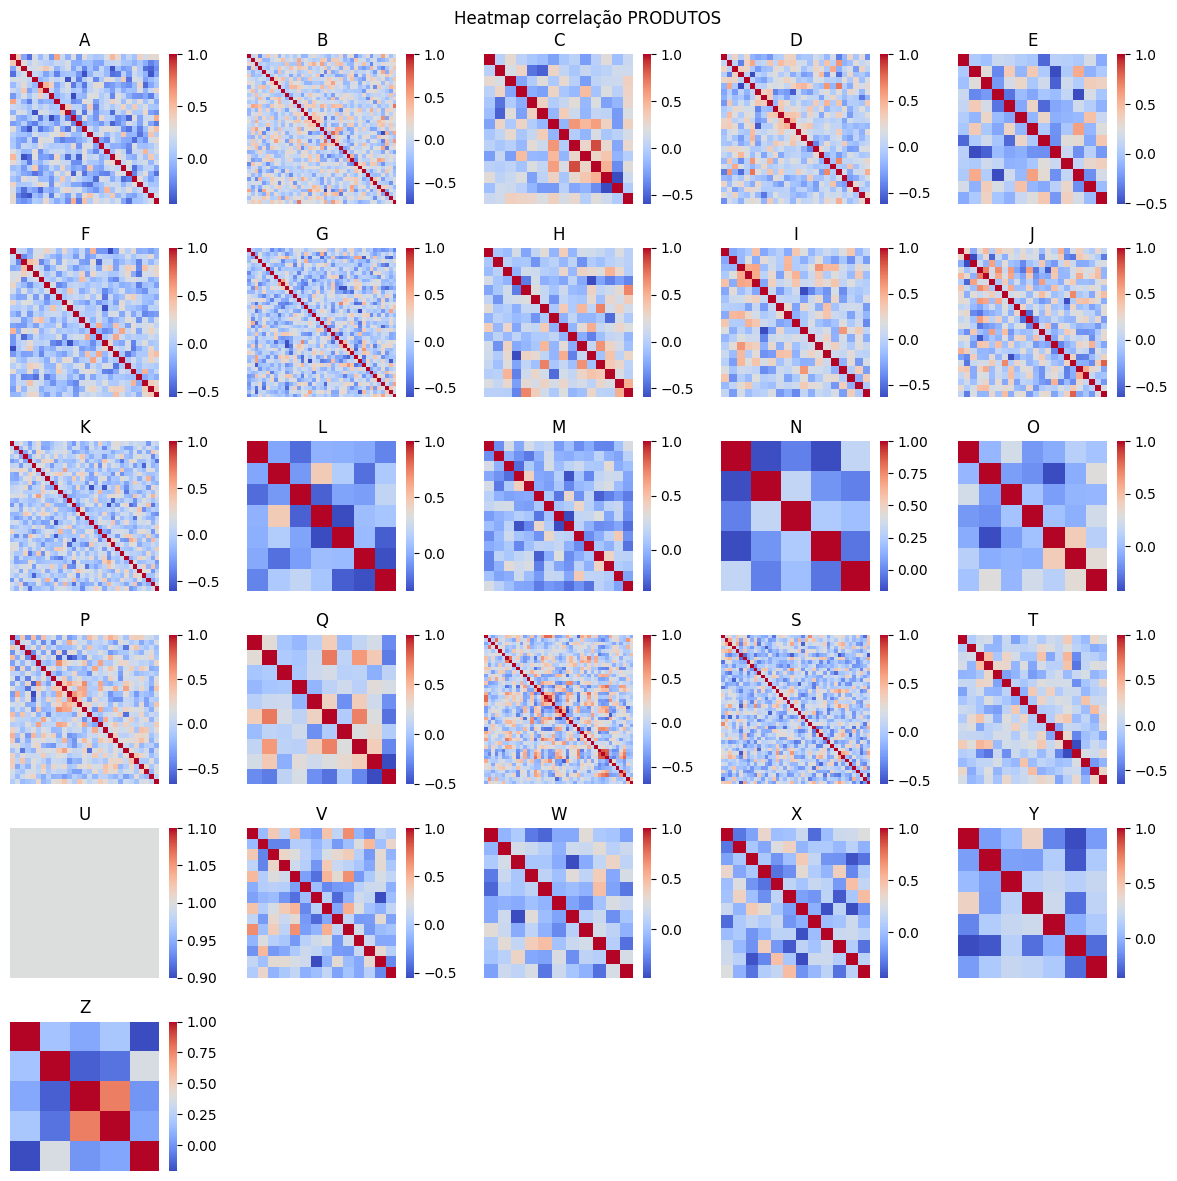

In [244]:
# heatmap das matriz de correlação para cada produto
# usando grids para visual mais compacto
fig, axes = plt.subplots(6, 5, figsize=(12, 12))
for i, (produto, ax) in enumerate(zip(df["PRODUTO"].unique(), axes.flat)):
    # break para testes
    if debug and i > 3:
        break
    sample_df_long = df_long[df_long["PRODUTO"] == produto]
    corr_matrix = sample_df_long.pivot(
        index="MESANO", columns=["KEY"], values="VENDAS"
    ).corr()
    sns.heatmap(corr_matrix, ax=ax, annot=False, cmap="coolwarm", square=True)
    ax.set_title(f"{produto}")
    ax.axis("off")
for ax in axes.flat[len(df["PRODUTO"].unique()) :]:
    ax.axis("off")
plt.suptitle("Heatmap correlação PRODUTOS")
plt.tight_layout()
plt.show()

### Correlação completa entre todas as combinações (Vendas)

In [245]:
corr_matrix = df_long.pivot(index="MESANO", columns=["KEY"], values="VENDAS").corr()

In [246]:
corr_long = pd.melt(
    corr_matrix.reset_index(),
    id_vars="KEY",
    var_name="KEY2",
    value_name="CORR",
)

In [247]:
threshold = 0
corr_long = corr_long[
    (threshold <= corr_long["CORR"])
    & (corr_long["CORR"] < 1)
    & (corr_long["KEY"] < corr_long["KEY2"])
]

In [248]:
df.columns[:7]

Index(['KEY', 'CATEGORIA', 'PRODUTO', 'FORNECEDOR', 'COMPRADOR',
       'CENTROS DE DISTRIBUICAO', 'DESCRICAO'],
      dtype='object')

In [249]:
# completa com dados originais para comparação
corr_long = (
    corr_long.merge(df[df.columns[:7]], on=["KEY"])
    .merge(df[df.columns[:7]], left_on="KEY2", right_on="KEY", suffixes=("", "_2"))
    .drop(columns="KEY_2")
)
corr_long.head()

,KEY,KEY2,CORR,CATEGORIA,PRODUTO,FORNECEDOR,COMPRADOR,CENTROS DE DISTRIBUICAO,DESCRICAO,CATEGORIA_2,PRODUTO_2,FORNECEDOR_2,COMPRADOR_2,CENTROS DE DISTRIBUICAO_2,DESCRICAO_2
0,AAAAAA,AAAAAT,0.436826,A,A,A,A,A,A,A,A,A,A,A,T
1,AAAAAT,AAAABB,0.321903,A,A,A,A,A,T,A,A,A,A,B,B
2,AAAAAT,AAAADT,0.125552,A,A,A,A,A,T,A,A,A,A,D,T
3,AAAABB,AAAADT,0.217063,A,A,A,A,B,B,A,A,A,A,D,T
4,AAAAAA,AAAAEE,0.242943,A,A,A,A,A,A,A,A,A,A,E,E


In [250]:
# identifica colunas em comum
corr_long_same_col = {}
for col in df.columns[1:7]:
    corr_long_same = corr_long[corr_long[col] == corr_long[col + "_2"]]
    corr_long_same_col[col] = corr_long_same["CORR"].agg(
        ["min", "max", "mean", "std", "count"]
    )

In [251]:
pd.DataFrame.from_dict(corr_long_same_col, orient="index")

,min,max,mean,std,count
CATEGORIA,0.000020,0.909686,0.184463,0.138316,25304.0
PRODUTO,0.000173,0.861914,0.195079,0.148373,3422.0
FORNECEDOR,0.000042,0.861914,0.189094,0.142364,5708.0
COMPRADOR,0.000042,0.861914,0.184623,0.138384,19672.0
CENTROS DE DISTRIBUICAO,0.000180,0.896532,0.192701,0.151234,3108.0
DESCRICAO,0.000324,0.861914,0.189587,0.139783,2356.0


Não há nenhuma característica que, para valores iguais, possua uma média de correlação alta entre suas séries de VENDAS.

### Correlação completa entre todas as combinações (Log Return das Vendas)

In [252]:
df_long = df_long.sort_values(["KEY", "MESANO"])
df_long["VENDAS_ANT"] = df_long.groupby("KEY")["VENDAS"].shift(1)
df_long["VENDAS_LOGRET"] = np.log(df_long["VENDAS"]) - np.log(df_long["VENDAS_ANT"])

c:\Users\Paulo\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [253]:
corr_matrix = df_long.pivot(
    index="MESANO", columns=["KEY"], values="VENDAS_LOGRET"
).corr()
corr_long = pd.melt(
    corr_matrix.reset_index(),
    id_vars="KEY",
    var_name="KEY2",
    value_name="CORR",
)
threshold = 0
corr_long = corr_long[
    (threshold <= corr_long["CORR"])
    & (corr_long["CORR"] < 1)
    & (corr_long["KEY"] < corr_long["KEY2"])
]
# completa com dados originais para comparação
corr_long = (
    corr_long.merge(df[df.columns[:7]], on=["KEY"])
    .merge(df[df.columns[:7]], left_on="KEY2", right_on="KEY", suffixes=("", "_2"))
    .drop(columns="KEY_2")
)
# identifica colunas em comum
corr_long_same_col = {}
for col in df.columns[1:7]:
    corr_long_same = corr_long[corr_long[col] == corr_long[col + "_2"]]
    corr_long_same_col[col] = corr_long_same["CORR"].agg(
        ["min", "max", "mean", "std", "count"]
    )
pd.DataFrame.from_dict(corr_long_same_col, orient="index")

,min,max,mean,std,count
CATEGORIA,0.000006,0.868138,0.200149,0.149294,24993.0
PRODUTO,0.000015,0.900182,0.210665,0.157741,3318.0
FORNECEDOR,0.000056,0.900182,0.204445,0.154469,5605.0
COMPRADOR,0.000031,0.900182,0.201375,0.150095,19590.0
CENTROS DE DISTRIBUICAO,0.000011,0.900182,0.206828,0.157415,2990.0
DESCRICAO,0.000205,0.815658,0.197969,0.146487,2371.0


Tampouco há nenhuma característica que, para valores iguais, possua uma média de correlação alta entre suas séries de Log Return de VENDAS.

### Correlação cruzada de vendas

In [254]:
corr_long

,KEY,KEY2,CORR,CATEGORIA,PRODUTO,FORNECEDOR,COMPRADOR,CENTROS DE DISTRIBUICAO,DESCRICAO,CATEGORIA_2,PRODUTO_2,FORNECEDOR_2,COMPRADOR_2,CENTROS DE DISTRIBUICAO_2,DESCRICAO_2
0,AAAAAA,AAAAAT,0.470750,A,A,A,A,A,A,A,A,A,A,A,T
1,AAAAAA,AAAAEE,0.107907,A,A,A,A,A,A,A,A,A,A,E,E
2,AAAABB,AAAAEE,0.210253,A,A,A,A,B,B,A,A,A,A,E,E
3,AAAAAA,AAAAEM,0.000093,A,A,A,A,A,A,A,A,A,A,E,M
4,AAAAAT,AAAAEM,0.076740,A,A,A,A,A,T,A,A,A,A,E,M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62989,EGRCAC,GVKBHO,0.211826,E,G,R,C,A,C,G,V,K,B,H,O
62990,EGRCHP,GVKBHO,0.181713,E,G,R,C,H,P,G,V,K,B,H,O
62991,EGRCJP,GVKBHO,0.255549,E,G,R,C,J,P,G,V,K,B,H,O
62992,FXKBGH,GVKBHO,0.466343,F,X,K,B,G,H,G,V,K,B,H,O


In [255]:
corr_long["CROSS_CORR_SCORE"] = 0.0

for idx, row in corr_long.iterrows():
    # break para testes
    if debug and idx > 1000:
        break
    df_key = df_long[df_long["KEY"] == row["KEY"]]
    df_key_ts = df_key.set_index("MESANO")["VENDAS"].fillna(0)[0:]
    df_key2 = df_long[df_long["KEY"] == row["KEY2"]]
    df_key_ts2 = df_key2.set_index("MESANO")["VENDAS"].fillna(0)[0:]
    cross_corr_values = ccf(df_key_ts, df_key_ts2)
    max_cross_corr = np.max(np.abs(cross_corr_values[:6]))  # máximo de 5 lags
    corr_long.loc[idx, "CROSS_CORR_SCORE"] = max_cross_corr

# identifica colunas em comum
corr_long_same_col = {}
for col in df.columns[1:7]:
    corr_long_same = corr_long[corr_long[col] == corr_long[col + "_2"]]
    corr_long_same_col[col] = corr_long_same["CROSS_CORR_SCORE"].agg(
        ["min", "max", "mean", "std", "count"]
    )
pd.DataFrame.from_dict(corr_long_same_col, orient="index")

,min,max,mean,std,count
CATEGORIA,0.048263,0.995389,0.356095,0.119014,24993.0
PRODUTO,0.048263,0.861914,0.358803,0.122092,3318.0
FORNECEDOR,0.036905,0.950929,0.358759,0.119990,5605.0
COMPRADOR,0.032203,1.082766,0.357878,0.119705,19590.0
CENTROS DE DISTRIBUICAO,0.068637,0.896532,0.359902,0.125180,2990.0
DESCRICAO,0.064780,0.889344,0.356230,0.121548,2371.0


$$ \text{Correlação cruzada mínima} = \text{SE (Erro Padrão)} \times \text{Valor crítico} $$
$$ \text{SE} = \frac{1}{\sqrt{N}} $$
Para uma confiança de 95%:
$$ \text{Valor crítico} = 1.69 $$
Sendo a série completa:
$$ N = 25 $$
Portanto:
$$ \text{Correlação cruzada mínima} = \frac{1}{\sqrt{25}} \times 1.96 = 0.2 \times 1.96 = 0.392 $$

Apesar de haver algumas séries cujo coeficiente de correlação cruzada mínima ultrapassa o limite de 0.392, a média delas para combinações de variável categórica com mesmo valor tem médias abaixo deste valor.\
A conclusão é que as séries temporais são independentes e não se justifica uma abordagem multivariada, mas sim forecasts independentes.

## Análise de Sazonalidade

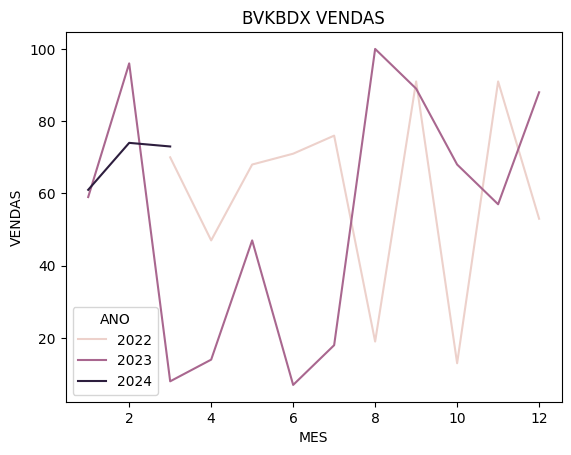

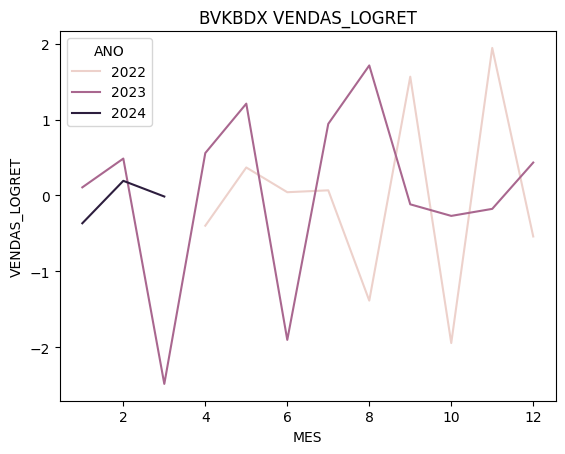

In [256]:
# Escolha de uma série aleatória e plot da série de Vendas e de Log Return de Vendas

random_key = np.random.choice(df["KEY"])
random_df = df_long[df_long["KEY"] == random_key]
sns.lineplot(x="MES", y="VENDAS", hue="ANO", data=random_df)
plt.title(random_key + " VENDAS")
plt.show()
sns.lineplot(x="MES", y="VENDAS_LOGRET", hue="ANO", data=random_df)
plt.title(random_key + " VENDAS_LOGRET")
plt.show()

Visualmente, não se encontra sazonalidade

In [257]:
random_df_ts = random_df.set_index("MESANO")["VENDAS_LOGRET"].fillna(0)[1:]
stl = STL(random_df_ts)
result = stl.fit()
result.seasonal.mean()

0.017104363742933698

In [258]:
df["SEASONAL_MEAN"] = 0
for idx, row in df.iterrows():
    df_key = df_long[df_long["KEY"] == row["KEY"]]
    df_key_ts = df_key.set_index("MESANO")["VENDAS_LOGRET"].fillna(0)[1:]
    stl = STL(df_key_ts, period=7)
    result = stl.fit()
    df.loc[idx, "SEASONAL_MEAN"] = result.seasonal.mean()

C:\Users\Paulo\AppData\Local\Temp\ipykernel_21272\899044227.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.009572310922476271' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[idx, "SEASONAL_MEAN"] = result.seasonal.mean()


In [259]:
df[["KEY", "SEASONAL_MEAN"]].sort_values("SEASONAL_MEAN", ascending=False)

,KEY,SEASONAL_MEAN
257,BBBBQX,0.136962
435,BVKBJR,0.131581
401,BMICSY,0.128627
226,BGFCNR,0.126293
415,BHGCAG,0.125748
...,...,...
181,BGFCSJ,-0.106680
313,AFQCCN,-0.111797
349,AIBBHN,-0.125083
278,BBBBEL,-0.132504


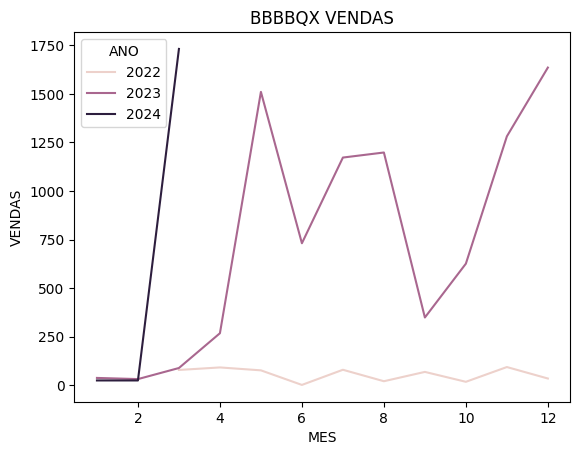

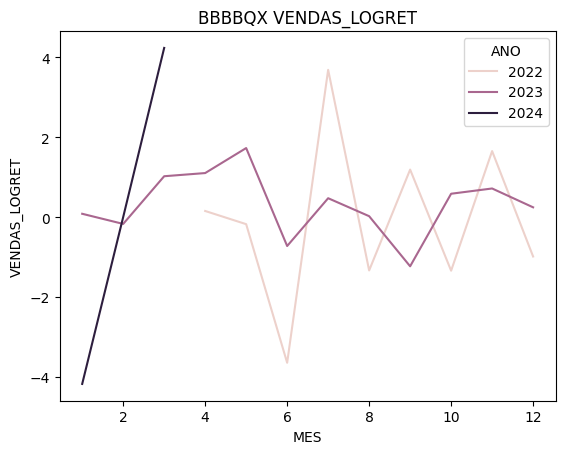

In [260]:
# plot da série de Vendas e de Log Return de Vendas

specific_key = "BBBBQX"
specific_df = df_long[df_long["KEY"] == specific_key]
sns.lineplot(x="MES", y="VENDAS", hue="ANO", data=specific_df)
plt.title(specific_key + " VENDAS")
plt.show()
sns.lineplot(x="MES", y="VENDAS_LOGRET", hue="ANO", data=specific_df)
plt.title(specific_key + " VENDAS_LOGRET")
plt.show()

Mesmo nas séries com os valores mais altos de média de componente sazonal, não parece haver sazonalidade.

## Análise de Estacionariedade

In [261]:
def time_difference(ts, d):
    for i in range(d):
        if ts.min() < 0.0:
            ts = ts - ts.min() + 1.0
        ts = (np.log(ts) - np.log(ts.shift(1)))[1:]
    if ts.min() < 0.0:
        ts = ts - ts.min() + 1.0
    return ts

In [262]:
df["ADF_P_VALUE"] = 0.0
df["ADF_D_VALUE"] = 0.0

for idx, row in df.iterrows():
    df_key = df_long[df_long["KEY"] == row["KEY"]]
    df_key_ts = df_key.set_index("MESANO")["VENDAS"].asfreq('MS')
    d = 0
    result = adfuller(df_key_ts)
    while result[1] > 0.05:
        df_key_ts = time_difference(df_key_ts, 1)
        result = adfuller(df_key_ts)
        d = d + 1
    df.loc[idx, "ADF_P_VALUE"] = result[1]
    df.loc[idx, "ADF_D_VALUE"] = d

In [263]:
df["ADF_D_VALUE"].value_counts()

ADF_D_VALUE
0.0     292
1.0     129
2.0      41
3.0      11
4.0      10
5.0       4
6.0       4
7.0       3
8.0       3
14.0      2
9.0       1
Name: count, dtype: int64

Acima temos o perfil das séries temporais com o número de derivadas necessárias para ter séries estacionárias.

## Avaliação de Autocorrelação (Q)


$$ \text{Fator de autocorrelação mínimo} = \text{SE (Erro Padrão)} \times \text{Valor crítico} $$
$$ \text{SE} = \frac{1}{\sqrt{N}} $$
Para uma confiança de 95%:
$$ \text{Valor crítico} = 1.69 $$ 
Sendo a série de treinamento:
$$ N = 20 $$
Portanto:
$$ \text{Fator de autocorrelação mínimo} = \frac{1}{\sqrt{20}} \times 1.96 = 0.223607 \times 1.96 = 0.438269 $$

In [264]:
df["ACF_Q"] = 0.0
lags = 20

for idx, row in df.iterrows():
    df_key = df_long[df_long["KEY"] == row["KEY"]]
    df_key_ts = df_key.set_index("MESANO")["VENDAS"].asfreq('MS')
    # split entre treinamento e teste
    train_size = int(len(df_key_ts) * 0.8)
    df_key_ts_train, df_key_ts_test = df_key_ts[:train_size], df_key_ts[train_size:]
    acf_values = acf(df_key_ts_train, nlags=lags)
    q = (pd.Series(np.abs(acf_values)) > 0.438269).idxmax()
    df.loc[idx, "ACF_Q"] = q

In [265]:
df["ACF_Q"].value_counts()

ACF_Q
0.0    500
Name: count, dtype: int64

Nenhuma série tem lags significativos para autocorrelação

## Avaliação de Autocorrelação Parcial (P)

In [266]:
df["PACF_P"] = 0.0
lags = 10

for idx, row in df.iterrows():
    df_key = df_long[df_long["KEY"] == row["KEY"]]
    df_key_ts = df_key.set_index("MESANO")["VENDAS"].asfreq('MS')
    # split entre treinamento e teste
    train_size = int(len(df_key_ts) * 0.8)
    df_key_ts_train, df_key_ts_test = df_key_ts[:train_size], df_key_ts[train_size:]
    pacf_values = pacf(df_key_ts_train, nlags=lags)
    p = (pd.Series(np.abs(pacf_values)) > 0.438269).idxmax()
    df.loc[idx, "PACF_P"] = p

In [267]:
df["PACF_P"].value_counts()

PACF_P
0.0    500
Name: count, dtype: int64

Nenhuma série tem lags significativos para autocorrelação parcial

## Modelagem e avaliação

Como os valores de autocorrelação e autocorrelação parcial das séries processadas são zero,\
possivelmente o modelo ETS não trará grande vantagem.

### ARIMA

In [268]:
import warnings

warnings.simplefilter("ignore", category=UserWarning)

In [269]:
df["ARIMA_MAE"] = 0.0
df["ARIMA_MSE"] = 0.0
df["ARIMA_RMSE"] = 0.0
df["ARIMA_MAPE"] = 0.0
df["ARIMA_WMAPE"] = 0.0

for idx, row in df.iterrows():
    if debug and idx > 15:
        break
    # obtenção da ST
    df_key = df_long[df_long["KEY"] == row["KEY"]]
    df_key_ts = df_key.set_index("MESANO")["VENDAS"].asfreq("MS")
    # split entre treinamento e teste
    train_size = int(len(df_key_ts) * 0.8)
    df_key_ts_train, df_key_ts_test = df_key_ts[:train_size], df_key_ts[train_size:]
    # modelo, treino e forecast
    model = ARIMA(df_key_ts_train, order=(row["PACF_P"], row["ADF_D_VALUE"], row["ACF_Q"]))
    model_fit = model.fit()
    df_key_ts_forecast = model_fit.forecast(steps=len(df_key_ts_test))
    # avaliação
    mae = mean_absolute_error(df_key_ts_test, df_key_ts_forecast)
    mse = mean_squared_error(df_key_ts_test, df_key_ts_forecast)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((df_key_ts_test - df_key_ts_forecast) / df_key_ts_test)) * 100
    wmape = (
        np.sum(np.abs(df_key_ts_test - df_key_ts_forecast))
        / np.sum(np.abs(df_key_ts_test))
        * 100
    )
    df.loc[idx, "ARIMA_MAE"] = mae
    df.loc[idx, "ARIMA_MSE"] = mse
    df.loc[idx, "ARIMA_RMSE"] = rmse
    df.loc[idx, "ARIMA_MAPE"] = mape
    df.loc[idx, "ARIMA_WMAPE"] = wmape

In [270]:
df[df.columns[1:6].append(df.columns[-7:])].head()

,CATEGORIA,PRODUTO,FORNECEDOR,COMPRADOR,CENTROS DE DISTRIBUICAO,ACF_Q,PACF_P,ARIMA_MAE,ARIMA_MSE,ARIMA_RMSE,ARIMA_MAPE,ARIMA_WMAPE
0,A,A,A,A,A,0.0,0.0,1.582100e+02,2.763488e+04,1.662374e+02,65.327699,52.526559
1,A,A,A,A,B,0.0,0.0,1.229234e+06,3.452645e+12,1.858129e+06,65068.776956,66857.065158
2,B,B,B,B,C,0.0,0.0,4.265001e+01,1.931183e+03,4.394523e+01,29.882299,30.291198
3,B,C,C,C,D,0.0,0.0,1.476000e+02,3.753880e+04,1.937493e+02,25.692699,29.285714
4,A,D,A,A,E,0.0,0.0,3.185000e+01,1.142563e+03,3.380181e+01,142.208254,58.763840


A métrica que considero mais adequada para este tipo de problema é RMSE, pois penaliza erros grandes, o que considero necessário em um forecast de 12 períodos.

### ETS

In [271]:
df["ETS_MAE"] = 0.0
df["ETS_MSE"] = 0.0
df["ETS_RMSE"] = 0.0
df["ETS_MAPE"] = 0.0
df["ETS_WMAPE"] = 0.0

for idx, row in df.iterrows():
    if debug and idx > 15:
        break
    # obtenção da ST
    df_key = df_long[df_long["KEY"] == row["KEY"]]
    df_key_ts = df_key.set_index("MESANO")["VENDAS"].asfreq("MS")
    # split entre treinamento e teste
    train_size = int(len(df_key_ts) * 0.8)
    df_key_ts_train, df_key_ts_test = df_key_ts[:train_size], df_key_ts[train_size:]
    # modelo, treino e forecast
    model = ExponentialSmoothing(df_key_ts_train, trend='add', seasonal='add', seasonal_periods=6)
    model_fit = model.fit()
    df_key_ts_forecast = model_fit.forecast(steps=len(df_key_ts_test))
    # avaliação
    mae = mean_absolute_error(df_key_ts_test, df_key_ts_forecast)
    mse = mean_squared_error(df_key_ts_test, df_key_ts_forecast)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((df_key_ts_test - df_key_ts_forecast) / df_key_ts_test)) * 100
    wmape = (
        np.sum(np.abs(df_key_ts_test - df_key_ts_forecast))
        / np.sum(np.abs(df_key_ts_test))
        * 100
    )
    df.loc[idx, "ETS_MAE"] = mae
    df.loc[idx, "ETS_MSE"] = mse
    df.loc[idx, "ETS_RMSE"] = rmse
    df.loc[idx, "ETS_MAPE"] = mape
    df.loc[idx, "ETS_WMAPE"] = wmape

In [272]:
df[df.columns[1:6].append(df.columns[-5:])].head()

,CATEGORIA,PRODUTO,FORNECEDOR,COMPRADOR,CENTROS DE DISTRIBUICAO,ETS_MAE,ETS_MSE,ETS_RMSE,ETS_MAPE,ETS_WMAPE
0,A,A,A,A,A,171.375630,36398.920937,190.785012,72.722112,56.897620
1,A,A,A,A,B,318.916033,218906.478474,467.874426,20.945583,17.345591
2,B,B,B,B,C,32.874633,1605.177974,40.064672,23.325167,23.348461
3,B,C,C,C,D,144.893708,49782.906987,223.120835,21.930469,28.748752
4,A,D,A,A,E,30.338354,1600.571804,40.007147,172.318773,55.974823


### Comparação entre modelos

In [273]:
(df["ARIMA_RMSE"]>df["ETS_RMSE"]).value_counts()

False    293
True     207
Name: count, dtype: int64

Na quase totalidade das séries, ETS teve uma performance superior comparando `RMSE`

In [274]:
(df["ARIMA_WMAPE"]>df["ETS_WMAPE"]).value_counts()

False    276
True     224
Name: count, dtype: int64

Da mesma forma, utilizando WMAPE, ETS também teve uma performance superior na grande maioria dos casos.\
Se mais análises forem efetuadas sobre os dados e houver a conclusão de que há muitos picos extremos, talvez a mudança para WMAPE seja adequada, pois não haveria a distorção que outliers podem provocar em RMSE, já que este último penaliza muito grandes diferenças.

Os principais insights para o negócio são:
- as séries não apresentam clara tendência ou sazonalidade, se aproximando mais a um passeio aleatório
- para poder identificar melhor sazonalidade, séries temporais mais longas são necessárias
  - 25 é um comprimento muito curto, pois com apenas 80% da série para treinamento (20 períodos) a autocorrelação parcial não consegue encontrar um parâmetro útil para o modelo ARIMA